In [1]:
import os
import copy
import shutil
import math
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import logging
from torch.utils.tensorboard import SummaryWriter

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

2024-08-04 17:50:05.774588: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-04 17:50:06.078043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, data_start = 'stn', label_start = 'ecog', normalize=True, device="cuda"):
        self.data_dir = data_dir
        self.data_start = data_start
        self.label_start = label_start
        self.normalize = normalize
        self.device = device
        self.data_files = sorted([f for f in os.listdir(data_dir) if f.startswith(data_start)])
        self.label_files = sorted([f for f in os.listdir(data_dir) if f.startswith(label_start)])
        
        if len(self.data_files) == 0 or len(self.label_files) == 0:
            raise ValueError("No data or label files found in the specified directory.")

        print(f"Found {len(self.data_files)} data files and {len(self.label_files)} label files.")

        # Load all data to fit the scaler
        all_data = []
        all_labels = []
        for data_file, label_file in zip(self.data_files, self.label_files):
            data_path = os.path.join(data_dir, data_file)
            label_path = os.path.join(data_dir, label_file)
            data = np.load(data_path)
            label = np.load(label_path)
            all_data.append(data)
            all_labels.append(label)
            
        all_data = np.vstack(all_data)
        all_labels = np.vstack(all_labels)

        # Fit scalers on data and labels
        self.data_scaler = MinMaxScaler()
        self.label_scaler = MinMaxScaler()
        
        self.data_scaler.fit(all_data)
        self.label_scaler.fit(all_labels)
    
    def __len__(self):
        return len(self.data_files)
    
    def normalization_data(self, data):
        normalized_data = self.data_scaler.transform(data)
        return normalized_data

    def normalization_label(self, label):
        normalized_label = self.data_scaler.transform(label)
        return normalized_label
    
    def __getitem__(self, idx):
        data_path = os.path.join(self.data_dir, self.data_files[idx])
        label_path = os.path.join(self.data_dir, self.label_files[idx])
        
        data = np.load(data_path)
        label = np.load(label_path)
        
        if self.normalize:
            # Normalize data and labels
            data = self.normalization_data(data)
            label = self.normalization_label(label)
        
        data = torch.tensor(data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        
        return data, label
    
    def inverse_transform_data(self, normalized_data, mode):
        # Assuming normalized_data is a numpy array
        if mode == "numpy":
            original_scale_data = self.data_scaler.inverse_transform(normalized_data)
        elif mode == "tensor":
            # Flatten the 4D tensor to 2D, keeping the last dimension if necessary
            original_shape = normalized_data.shape
            if len(original_shape) > 2:
                flattened_data = normalized_data.view(-1, original_shape[-1]).detach().cpu().numpy()
            else:
                flattened_data = normalized_data.detach().cpu().numpy()
            
            # Apply the inverse transform
            numpy_original = self.data_scaler.inverse_transform(flattened_data)
            
            # Reshape back to the original shape
            if len(original_shape) > 2:
                reshaped_original = numpy_original.reshape(original_shape)
            else:
                reshaped_original = numpy_original
            
            original_scale_data = torch.from_numpy(reshaped_original).to(self.device)
        return original_scale_data

    def inverse_transform_label(self, normalized_label, mode):
        # Assuming normalized_data is a numpy array
        if mode == "numpy":
            original_scale_label = self.data_scaler.inverse_transform(normalized_label)
        elif mode == "tensor":
            # Flatten the 4D tensor to 2D, keeping the last dimension if necessary
            original_shape = normalized_label.shape
            if len(original_shape) > 2:
                flattened_label = normalized_label.view(-1, original_shape[-1]).detach().cpu().numpy()
            else:
                flattened_label = normalized_label.detach().cpu().numpy()
            
            # Apply the inverse transform
            numpy_original = self.data_scaler.inverse_transform(flattened_label)
            
            # Reshape back to the original shape
            if len(original_shape) > 2:
                reshaped_original = numpy_original.reshape(original_shape)
            else:
                reshaped_original = numpy_original
            
            original_scale_label = torch.from_numpy(reshaped_original).to(self.device)
        return original_scale_label


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape 
        
        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape 

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)
        
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1) 
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf) 
        
        # Divide by d_k (Dim / H). 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head) 

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1) 

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2) 

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output) 
        
        # (Batch_Size, Seq_Len, Dim)
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.d_cross = d_cross
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    # def flatten_last_two_dims(self, tensor):
    #     # Calculate the size of the flattened dimension
    #     last_dim_size = tensor.size(-1)
    #     second_last_dim_size = tensor.size(-2)
    #     flattened_dim_size = last_dim_size * second_last_dim_size

    #     # Create the new shape
    #     new_shape = tensor.size()[:-2] + (flattened_dim_size,)

    #     # Reshape the tensor
    #     flattened_tensor = tensor.view(new_shape)
    #     return flattened_tensor
    
    # def cos_embedding(self, x, channels):
    #     """
    #     Computes cosine embeddings for the input tensor.
        
    #     Args:
    #         x (torch.Tensor): Input tensor of shape (batch_size, 2625).
    #         channels (int): Number of embedding channels.
        
    #     Returns:
    #         torch.Tensor: Tensor of shape (batch_size, 2625, channels*2) containing the cosine and sine embeddings.
    #     """
    #     batch_size, seq_len = x.size()
        
    #     # Create frequency embedding
    #     freqs = torch.pow(10000, -torch.arange(start=0, end=channels/2, dtype=torch.float32, device=x.device) / (channels/2)) 
        
    #     # Reshape to apply broadcasting
    #     freqs = freqs.view(1, 1, -1)
    #     x = x.view(batch_size, seq_len, 1)
        
    #     # Apply the cosine and sine functions
    #     t = x * freqs
    #     embeddings = torch.cat([torch.cos(t), torch.sin(t)], dim=-1)
        
    #     return embeddings
    
    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 2625, 160)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        # y = self.flatten_last_two_dims(y)
        # y = self.cos_embedding(y, self.d_cross)

        # if y is not None:
        #     print("y shape",y.shape)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)

        # if y is not None:
        #     print("quarry shape of x",q.shape)

        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)

        # if y is not None:
        #     print("key shape of y",k.shape)

        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # if y is not None:
        #     print("value shape of y",v.shape)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2) 
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()
        
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output


class TimeEmbedding(nn.Module):
    def __init__(self, n_embd, device='cuda'):
        super().__init__()
        self.device = device
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def get_time_embedding(timestep, channel):
        # Shape: (channel/2,)
        freqs = torch.pow(10000, -torch.arange(start=0, end=channel/2, dtype=torch.float32, device='cuda') / (channel/2)) 
        # Shape: (Batch_Size, channel/2)
        # t = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
        t = timestep[:, None] * freqs[None]
        # Shape: (Batch_Size, channel)
        return torch.cat([torch.cos(t), torch.sin(t)], dim=-1)
    
    # def time_encoding(t, channels):
    #     inv_freq = 1.0 / (
    #         10000 ** (torch.arange(0, channels, 2, device='cuda').float() / channels)
    #     )
    #     time_enc_sin = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    #     time_enc_cos = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    #     time_enc = torch.cat([time_enc_sin, time_enc_cos], dim=-1)
    #     return time_enc

    def forward(self, t):
        # t: (Batch_Size, Channel)

        # (Batch_Size, Channel) -> (Batch_Size, Channel * 4)
        # print("time step before linear:", t.shape)
        t = self.linear_1(t)
        # print("time step after linear:", t.shape)
        # (Batch_Size, Channel * 4) -> (Batch_Size, Channel * 4)
        t = F.silu(t) 
        
        # (1, 1280) -> (1, 1280)
        t = self.linear_2(t)

        return t

class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)

        self.groupnorm_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, feature, time):
        # feature: (Batch_Size, In_Channels, Height, Width)
        # time: (1, 1280)

        residue = feature
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = self.groupnorm_feature(feature)
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = F.silu(feature)
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        feature = self.conv_feature(feature)
        
        # (Batch_Size, 1280) -> (Batch_Size, 1280)
        time = F.silu(time)

        # (1, 1280) -> (1, Out_Channels)
        time = self.linear_time(time)
        
        # Add width and height dimension to time. 
        # (Batch_Size, Out_Channels, Height, Width) + (1, Out_Channels, 1, 1) -> (Batch_Size, Out_Channels, Height, Width)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.groupnorm_merged(merged)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = F.silu(merged)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.conv_merged(merged)
        
        # (Batch_Size, Out_Channels, Height, Width) + (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return merged + self.residual_layer(residue)

class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=160):
        super().__init__()
        channels = n_head * n_embd
        
        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)
    
    def forward(self, x, context):
        # x: (Batch_Size, Features, Height, Width)
        # context: (Batch_Size, Seq_Len, Dim)

        residue_long = x

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Widthquarry)
        x = self.groupnorm(x)
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.conv_input(x)
        
        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features)
        x = x.transpose(-1, -2)
        
        # Normalization + Self-Attention with skip connection

        # (Batch_Size, Height * Width, Features)
        residue_short = x
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_1(x)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_1(x)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # Normalization + Cross-Attention with skip connection
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_2(x)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        if context is not None:    
            x = self.attention_2(x, context)
        elif context is None:
            x = self.attention_1(x)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # Normalization + FFN with GeGLU and skip connection
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_3(x)
        
        # GeGLU as implemented in the original code: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/ldm/modules/attention.py#L37C10-L37C10
        # (Batch_Size, Height * Width, Features) -> two tensors of shape (Batch_Size, Height * Width, Features * 4)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1) 
        
        # Element-wise product: (Batch_Size, Height * Width, Features * 4) * (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features * 4)
        x = x * F.gelu(gate)
        
        # (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features)
        x = self.linear_geglu_2(x)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))

        # Final skip connection between initial input and output of the block
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        return self.conv_output(x) + residue_long

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
        x = F.interpolate(x, scale_factor=2, mode='nearest') 
        return self.conv(x)

class SwitchSequential(nn.Sequential):
    def forward(self, x, context, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x, context)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([
            # (Batch_Size, 1, Height, Width) -> (Batch_Size, 160, Height, Width)
            SwitchSequential(nn.Conv2d(1, 160, kernel_size=3, padding=1)),
            
            # (Batch_Size, 160, Height, Width) -> # (Batch_Size, 160, Height, Width) -> (Batch_Size, 160, Height, Width)
            SwitchSequential(UNET_ResidualBlock(160, 160), UNET_AttentionBlock(8, 20)),
            
            # (Batch_Size, 160, Height, Width) -> # (Batch_Size, 160, Height, Width) -> (Batch_Size, 160, Height, Width)
            SwitchSequential(UNET_ResidualBlock(160, 160), UNET_AttentionBlock(8, 20)),
            
            # (Batch_Size, 160, Height, Width) -> (Batch_Size, 160, Height / 2, Width / 2)
            SwitchSequential(nn.Conv2d(160, 160, kernel_size=3, stride=2, padding=1)),
            
            # (Batch_Size, 160, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2)
            SwitchSequential(UNET_ResidualBlock(160, 320), UNET_AttentionBlock(8, 40)),
            
            # (Batch_Size, 320, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2)
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            
            # (Batch_Size, 320, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 4, Width / 4)
            SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),
            
            # (Batch_Size, 320, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4)
            SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),
            
            # (Batch_Size, 640, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4)
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
            
            # (Batch_Size, 640, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 8, Width / 8)
            SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)),
            
            # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(640, 640)),
            
            # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(640, 640)),
        ])

        self.bottleneck = SwitchSequential(
            # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 8, Width / 8)
            UNET_ResidualBlock(640, 640), 
            
            # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 8, Width / 8)
            UNET_AttentionBlock(8, 80), 
            
            # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 8, Width / 8)
            UNET_ResidualBlock(640, 640), 
        )
        
        self.decoders = nn.ModuleList([
            # (Batch_Size, 1280, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(1280, 640)),
            
            # (Batch_Size, 1280, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(1280, 640)),
            
            # (Batch_Size, 1280, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 640, Height / 4, Width / 4) 
            SwitchSequential(UNET_ResidualBlock(1280, 640), Upsample(640)),
            
            # (Batch_Size, 1280, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4)
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),
            
            # (Batch_Size, 1280, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4)
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),
            
            # (Batch_Size, 960, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 4, Width / 4) -> (Batch_Size, 640, Height / 2, Width / 2)
            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),
            
            # (Batch_Size, 960, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2)
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),
            
            # (Batch_Size, 640, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2)
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
            
            # (Batch_Size, 480, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2) -> (Batch_Size, 320, Height / 2, Width / 2) -> (Batch_Size, 320, Height, Width)
            SwitchSequential(UNET_ResidualBlock(480, 320), UNET_AttentionBlock(8, 40), Upsample(320)),
            
            # (Batch_Size, 480, Height, Width) -> (Batch_Size, 160, Height, Width) -> (Batch_Size, 160, Height, Width)
            SwitchSequential(UNET_ResidualBlock(480, 160), UNET_AttentionBlock(8, 20)),
            
            # (Batch_Size, 320, Height, Width) -> (Batch_Size, 160, Height, Width) -> (Batch_Size, 160, Height, Width)
            SwitchSequential(UNET_ResidualBlock(320, 160), UNET_AttentionBlock(8, 20)),
            
            # (Batch_Size, 320, Height, Width) -> (Batch_Size, 160, Height, Width) -> (Batch_Size, 160, Height, Width)
            SwitchSequential(UNET_ResidualBlock(320, 160), UNET_AttentionBlock(8, 20)),
        ])


    def forward(self, x, context, time):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim) 
        # time: (1, 1280)

        skip_connections = []
        for layers in self.encoders:
            # print("x shape:",x.shape)
            # print("context shape:",context.shape)
            # print("time shape:",time.shape)
            x = layers(x, context, time)
            skip_connections.append(x)
            # print("skip_connection before pop:",skip_connection.shape)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            # x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
            skip_con = skip_connections.pop()
            # print(f"x shape: {x.shape}, skip_connection shape: {skip_con.shape}")
            # Since we always concat with the skip connection of the encoder, the number of features increases before being sent to the decoder's layer
            x = torch.cat((x, skip_con), dim=1) 
            x = layers(x, context, time)
        
        return x


class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        # x: (Batch_Size, 160, Height, Width)

        # (Batch_Size, 160, Height, Width) -> (Batch_Size, 160, Height, Width)
        x = self.groupnorm(x)
        
        # (Batch_Size, 160, Height, Width) -> (Batch_Size, 160, Height, Width)
        x = F.silu(x)
        
        # (Batch_Size, 160, Height, Width) -> (Batch_Size, 1, Height, Width)
        x = self.conv(x)
        
        # (Batch_Size, 1, Height, Width) 
        return x

class UNet_conditional(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(160, 1)

    # Function to pad data to make it 32-divisible
    def padding(self, original_data, divisor):
        if original_data is None:
            return None
        height, width = original_data.shape[-2:]
        pad_height = (divisor - height % divisor) % (divisor)
        pad_width = (divisor- width % divisor) % (divisor)
        padding = (0, pad_width, 0, pad_height)
        padded_tensor = F.pad(original_data, padding, mode='constant', value=0)

        return padded_tensor
    
    def forward(self, data, condition, time):
        # data: (Batch_Size, 1, Height, Width)
        # condition: (Batch_Size, Seq_Len, Dim)
        # time: (Batch_Size, 320)

        # (Batch_Size, 320) -> (Batch_Size, 1280)
        time = TimeEmbedding.get_time_embedding(time, 320)
        
        time = self.time_embedding(time)

        data = self.padding(data,8)
        
        # (Batch, 1, Height, Width) -> (Batch, 160, Height, Width)
        output = self.unet(data, condition, time)
        
        # (Batch, 160, Height, Width) -> (Batch, 1, Height, Width)
        output = self.final(output)
        
        # (Batch, 1, Height, Width)
        return output

In [4]:
class Diffusion_Conditional:
    def __init__(self, data_path, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=(6, 375), divisor = 32 , device="cuda"):
        self.data_path = data_path
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device
        self.divisor = divisor

    # Function to pad data to make it 32-divisible
    def padding(original_data, divisor):
        if original_data is None:
            return None
        height, width = original_data.shape[-2:]
        pad_height = (divisor - height % divisor) % (divisor)
        pad_width = (divisor- width % divisor) % (divisor)
        padding = (0, pad_width, 0, pad_height)
        padded_tensor = F.pad(original_data, padding, mode='constant', value=0)

        return padded_tensor
    
    def get_named_beta_schedule(self, schedule_name, num_diffusion_timesteps):
        if schedule_name == 'linear':
            scale = 1000 / num_diffusion_timesteps
            betas = np.linspace(scale * 0.0001, scale * 0.02, num_diffusion_timesteps, dtype=np.float64)
        elif schedule_name == 'cosine':
            timesteps = np.arange(num_diffusion_timesteps + 1, dtype=np.float64) / num_diffusion_timesteps
            alphas_cumprod = np.cos((timesteps + 0.008) / 1.008 * np.pi / 2) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
            betas = np.clip(betas, a_min=0, a_max=0.999)
        else:
            raise NotImplementedError(f'unknown beta schedule: {schedule_name}')
        return betas

    def prepare_noise_schedule(self, schedule_name='cosine'):
        if schedule_name == 'linear':
            linear_procedure = torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
            return linear_procedure
        elif schedule_name == 'cosine':
            betas = self.get_named_beta_schedule('cosine', self.noise_steps)
            return torch.tensor(betas, dtype=torch.float32)
        else:
            raise ValueError("Unknown schedule_name. Use 'linear' or 'cosine'.")

    def sample_timesteps(self, n):
        return torch.randint(low=0, high=self.noise_steps, size=(n,)).long().to(self.device)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        # print("Ɛ dimension",Ɛ.shape)
        # Ɛ = (Ɛ - torch.min(Ɛ)) / (torch.max(Ɛ) - torch.min(Ɛ))
        # Ɛ = dataset.inverse_transform_data(Ɛ, mode="tensor")
        # print("Ɛ content", Ɛ)
        x_t = sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ
        return x_t, Ɛ
    
    def flatten_last_two_dims(self, tensor):
        # Calculate the size of the flattened dimension
        last_dim_size = tensor.size(-1)
        second_last_dim_size = tensor.size(-2)
        flattened_dim_size = last_dim_size * second_last_dim_size

        # Create the new shape
        new_shape = tensor.size()[:-2] + (flattened_dim_size,)

        # Reshape the tensor
        flattened_tensor = tensor.view(new_shape)
        return flattened_tensor
    
    def cos_embedding(self, x, channels):
        """
        Computes cosine embeddings for the input tensor.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 2625).
            channels (int): Number of embedding channels.
        
        Returns:
            torch.Tensor: Tensor of shape (batch_size, 2625, channels*2) containing the cosine and sine embeddings.
        """
        batch_size, seq_len = x.size()
        
        # Create frequency embedding
        freqs = torch.pow(10000, -torch.arange(start=0, end=channels/2, dtype=torch.float32, device=x.device) / (channels/2)) 
        
        # Reshape to apply broadcasting
        freqs = freqs.view(1, 1, -1)
        x = x.view(batch_size, seq_len, 1)
        
        # Apply the cosine and sine functions
        t = x * freqs
        embeddings = torch.cat([torch.cos(t), torch.sin(t)], dim=-1)
        
        return embeddings

    def sample(self, model, n, labels, d_cross=160, data_start='stn', label_start='ecog', cfg_scale=3):
        logging.info(f"Sampling {n} new data based on label guidance....")
        dataset = CustomDataset(self.data_path , data_start = data_start, label_start = label_start, normalize=True)
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, *self.img_size)).to(self.device)
            # x = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
            # x = dataset.inverse_transform_data(x, mode="tensor")
            # x = self.padding(x, divisor=32)
            # print("x before model: ",x.shape)
            for i in tqdm(reversed(range(1, self.noise_steps))):
                t = (torch.ones(n) * i).long().to(self.device)
                # print("timestep t:",t)

                # labels = self.flatten_last_two_dims(labels)
                # labels = self.cos_embedding(labels, d_cross).to(self.device)

                # print("labels shape before model",labels.shape)
                predicted_noise = model(data=x, condition=labels, time=t)
                # print("predicted_noise ",predicted_noise.shape)
                if cfg_scale > 0:
                    unconditional_predicted_noise = model(data=x, condition=None, time=t)
                    predicted_noise = torch.lerp(unconditional_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                    # print("noise dimension", noise.shape)
                    # Normalize the tensor noise
                    # noise = (noise - torch.min(noise)) / (torch.max(noise) - torch.min(noise))
                    # noise = dataset.inverse_transform_data(noise, mode="tensor")
                else:
                    noise = torch.zeros_like(x)
                # print("x shape",x.shape)
                # print("noise shape",noise.shape)
                batch_size, seq_len, img_size_1, img_size_2 = x.size()
                predicted_noise = predicted_noise[:, :, :img_size_1, :img_size_2]
                x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_hat)) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
        # x = (x.clamp(-1, 1) + 1) / 2
        # # reverse normalization
        x = dataset.inverse_transform_data(x, mode="tensor")
        return x

In [5]:
# Training function
def flatten_last_two_dims(tensor):
        # Calculate the size of the flattened dimension
        last_dim_size = tensor.size(-1)
        second_last_dim_size = tensor.size(-2)
        flattened_dim_size = last_dim_size * second_last_dim_size

        # Create the new shape
        new_shape = tensor.size()[:-2] + (flattened_dim_size,)

        # Reshape the tensor
        flattened_tensor = tensor.view(new_shape)
        return flattened_tensor
    
def cos_embedding(x, channels):
    """
    Computes cosine embeddings for the input tensor.
    
    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, 2625).
        channels (int): Number of embedding channels.
    
    Returns:
        torch.Tensor: Tensor of shape (batch_size, 2625, channels*2) containing the cosine and sine embeddings.
    """
    batch_size, seq_len = x.size()
    
    # Create frequency embeddingSelfAtt
    freqs = torch.pow(10000, -torch.arange(start=0, end=channels/2, dtype=torch.float32, device=x.device) / (channels/2)) 
    
    # Reshape to apply broadcasting
    freqs = freqs.view(1, 1, -1)
    x = x.view(batch_size, seq_len, 1)
    
    # Apply the cosine and sine functions
    t = x * freqs
    embeddings = torch.cat([torch.cos(t), torch.sin(t)], dim=-1)

    return embeddings


def train_model(batch_size, model, data_dir, data_start, label_start, d_cross, diffusion, epochs=500, lr=1e-9, device='cuda'):
    dataset = CustomDataset(data_dir , data_start = data_start, label_start = label_start, normalize=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    ema = EMA(beta=0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)
    logger = SummaryWriter(os.path.join("runs", "DDPM_conditional"))
    l = len(dataloader)

    for batch in dataloader:
        data, labels = batch
        print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
        break
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() # print("x shape:",x.shape)
            # print("context shape:",context.shape)
            # print("time shape:",time.shape)

    model.train()
    loss_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (data, labels) in enumerate(tqdm(dataloader)):
            # Ensure data has the correct shape: [batch_size, 1, height, width]
            if data.dim() == 3:  # If data is [batch_size, height, width], add channel dimension
                data = data.unsqueeze(1)
            # print("data shape:",data.shape)

            labels = flatten_last_two_dims(labels)
            labels = cos_embedding(labels, d_cross)

            data, labels = data.to(device), labels.to(device)
            t = diffusion.sample_timesteps(data.size(0))
            # print("t_diffusion shape",t.shape)
            x_t, noise = diffusion.noise_images(data, t)
            # print("x_t shape",x_t.shape)
            # print("noise shape",noise.shape)
            

            # Classifier free guidance require 10% none label generation
            if np.random.random()<0.1:
                labels = None

            # print("padded_labels shape",labels.shape)
            x_t = Diffusion_Conditional.padding(x_t, divisor=8)
            predicted_noise = model(data=x_t, condition=labels, time=t)
            # predicted_noise = (predicted_noise - torch.min(predicted_noise)) / (torch.max(predicted_noise) - torch.min(predicted_noise))
            # print("predicted_noise shape",predicted_noise.shape)

            # noise = (noise - torch.min(noise)) / (torch.max(noise) - torch.min(noise))
            noise = Diffusion_Conditional.padding(noise, divisor=8)

            # if torch.max(predicted_noise)>1:
            #     print(predicted_noise)
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()

            # EMA implementation
            ema.step_ema(ema_model,model)

            running_loss += loss.item() * data.size(0)

            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        epoch_loss = running_loss / len(dataloader.dataset)
        loss_values.append(epoch_loss) 
        logging.info(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

        if epoch % 10 == 0:
            # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
            # save_images(ema_sampled_images, os.path.join("results", args.run_name, f"{epoch}_ema.jpg"))
            torch.save(model.state_dict(), os.path.join("models", "DDPM_conditional", f"diffusion_model_conditional.pt"))
            torch.save(ema_model.state_dict(), os.path.join("models", "DDPM_conditional", f"ema_diffusion_model_conditional.pt"))
            torch.save(optimizer.state_dict(), os.path.join("models", "DDPM_conditional", f"optimizer.pt"))

    plt.figure()
    plt.plot(range(1, epochs + 1), loss_values, marker='o', markersize=3, linestyle='-', color='b')
    plt.title('MSE Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.savefig(os.path.join("models", "DDPM_conditional",'mse_loss_over_epochs.png'))
    plt.close()

    logging.info("Training complete")

In [6]:
# Train the model
batch_size = 3

current_path = os.getcwd()
data_dir = os.path.join(current_path, 'model_training_data/train_set')
data_normalization = True
data_start = 'stn'
label_start = 'ecog'
dataset = CustomDataset(data_dir , data_start = data_start, label_start = label_start, normalize=data_normalization)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet_conditional().to(device)
img_size = (6,375)
d_cross = 160
diffusion = Diffusion_Conditional(data_path=data_dir, img_size=img_size, device=device)

train_model(batch_size= batch_size, model=model, data_dir=data_dir, data_start=data_start, label_start=label_start, d_cross=d_cross, diffusion=diffusion, epochs=1200, lr=1e-9*(np.sqrt(batch_size/2)), device=device)

Found 159 data files and 159 label files.
Found 159 data files and 159 label files.
Data shape: torch.Size([3, 6, 375]), Labels shape: torch.Size([3, 7, 375])


100%|██████████| 53/53 [00:26<00:00,  2.02it/s]
05:50:37 - INFO: Epoch [1/1200], Loss: 0.8897
100%|██████████| 53/53 [00:25<00:00,  2.06it/s]
05:51:06 - INFO: Epoch [2/1200], Loss: 0.8866
100%|██████████| 53/53 [00:26<00:00,  2.03it/s]
05:51:32 - INFO: Epoch [3/1200], Loss: 0.8862
100%|██████████| 53/53 [00:27<00:00,  1.95it/s]
05:52:00 - INFO: Epoch [4/1200], Loss: 0.8849
100%|██████████| 53/53 [00:27<00:00,  1.90it/s]
05:52:28 - INFO: Epoch [5/1200], Loss: 0.8813
100%|██████████| 53/53 [00:26<00:00,  1.98it/s]
05:52:54 - INFO: Epoch [6/1200], Loss: 0.8796
100%|██████████| 53/53 [00:34<00:00,  1.52it/s]
05:53:29 - INFO: Epoch [7/1200], Loss: 0.8795
100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
05:54:07 - INFO: Epoch [8/1200], Loss: 0.8782
100%|██████████| 53/53 [00:40<00:00,  1.32it/s]
05:54:47 - INFO: Epoch [9/1200], Loss: 0.8756
100%|██████████| 53/53 [00:39<00:00,  1.33it/s]
05:55:27 - INFO: Epoch [10/1200], Loss: 0.8748
100%|██████████| 53/53 [00:28<00:00,  1.86it/s]
05:55:55 - 

In [7]:
# Sampling function
# def sample_images(model, diffusion, n=1, labels=None, device='cuda'):
#     model.eval()
#     with torch.no_grad():
#         samples = diffusion.sample(
#             model,
#             n,
#             labels.to(device) if labels is not None else None,
#             d_cross=160,
#             data_start='stn',
#             label_start='ecog',
#             cfg_scale=3,
#         )
#     return samples.cpu().numpy()

# Function to pad data to make it some number-divisible
def padding(data, divider):
    pad_height = (divider - data.shape[0] % divider) % divider
    pad_width = (divider - data.shape[1] % divider) % divider
    padded_data = np.pad(data, ((0, pad_height), (0, pad_width)), mode='constant')
    return padded_data

def load_ema_model(model, ema_checkpoint_path):
    checkpoint = torch.load(ema_checkpoint_path, map_location='cuda')
    model.load_state_dict(checkpoint['model_state_dict'])
    return model


In [8]:
# Example usage of the sampling function
# Assuming new_labels is a tensor of the same shape as your label data

current_path = os.getcwd()
model_path = os.path.join(current_path, 'models/DDPM_conditional/diffusion_model_conditional.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet_conditional().to(device)
model.load_state_dict(torch.load(model_path))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_size = (6,375)

d_cross = 160

current_path = os.getcwd()

data_start = 'stn'
label_start = 'ecog'

# img_size = (6,375)

# current_path = os.getcwd()
validation_dir = os.path.join(current_path, 'model_training_data/validation_set')
data_dir = os.path.join(current_path, 'model_training_data/train_set')

eval_data = np.load(validation_dir + '/stn_15.npy')
eval_label = np.load(validation_dir + '/ecog_15.npy')

data_dir = os.path.join(current_path, 'model_training_data/train_set')

dataset = CustomDataset(data_dir , data_start = data_start, label_start = label_start)

diffusion = Diffusion_Conditional(data_path=data_dir, img_size=img_size, device=device)

# Normalize eval_label using the dataset instance
normal_eval_label = dataset.normalization_label(eval_label)
# pad_eval_label = padding(normal_eval_label)

print("normal_eval_label shape:",normal_eval_label.shape)

eval_label_torch = torch.tensor(normal_eval_label, dtype=torch.float32).unsqueeze(0)  # Update with actual path

print("eval_label_torch shape:",eval_label_torch.shape)

# model, n, labels, d_cross, data_start='stn', label_start='ecog', cfg_scale=3, eval_mode=False

normal_eval_label = torch.tensor(normal_eval_label, dtype=torch.float32).unsqueeze(0)

print("label data shape beforce flatten:",normal_eval_label.shape)
labels = flatten_last_two_dims(normal_eval_label)
print("label data shape after flatten:",labels.shape)
labels = cos_embedding(labels, d_cross).to(device)


generated_samples = diffusion.sample(model=model, n=1, d_cross=160, labels=labels, data_start='stn', label_start='ecog', cfg_scale=3) 

04:13:00 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
normal_eval_label shape: (7, 375)
eval_label_torch shape: torch.Size([1, 7, 375])
label data shape beforce flatten: torch.Size([1, 7, 375])
label data shape after flatten: torch.Size([1, 2625])
Found 159 data files and 159 label files.


999it [01:55,  8.68it/s]


In [9]:
print(generated_samples.shape)

reduced_generated_samples = generated_samples[0, 0, :, :].cpu().numpy()

print(reduced_generated_samples.shape)

# generated_stn = dataset.inverse_transform_data(reduced_generated_samples,mode="numpy")
generated_stn = reduced_generated_samples
# generated_stn = dataset.inverse_transform_data(generated_stn,mode="numpy")

print(reduced_generated_samples.shape)

max_generated = np.max(reduced_generated_samples)
print(max_generated)
min_generated = np.min(reduced_generated_samples)
print(min_generated)

max_GT = np.max(eval_data)
print(max_GT)
min_GT = np.min(eval_data)
print(min_GT)

generated_folder = current_path+ '/model_generated_data'
if not os.path.exists(generated_folder):
    os.makedirs(generated_folder)

generated_name = "generated_stn_15"
np.save('%s/%s'%(generated_folder, generated_name), generated_stn)

torch.Size([1, 1, 6, 375])
(6, 375)
(6, 375)
1.14990435e-05
-1.4586487e-05
1.2358666936052032e-05
-1.2479285942390561e-05


General Pearson correlation: -0.0343728566823722
Pearson correlation with Gaussian noise: 0.12471193715075807
Correlation of generated data and ground truth at Channel 1: -0.020702643190354753
-------------------------------------------------
Correlation of generated data and ground truth at Channel 2: -0.10539419859204777
-------------------------------------------------
Correlation of generated data and ground truth at Channel 3: -0.052960109190887575
-------------------------------------------------
Correlation of generated data and ground truth at Channel 4: 0.037984030035897495
-------------------------------------------------
Correlation of generated data and ground truth at Channel 5: 0.012916565709466286
-------------------------------------------------
Correlation of generated data and ground truth at Channel 6: -0.071084565902781
-------------------------------------------------


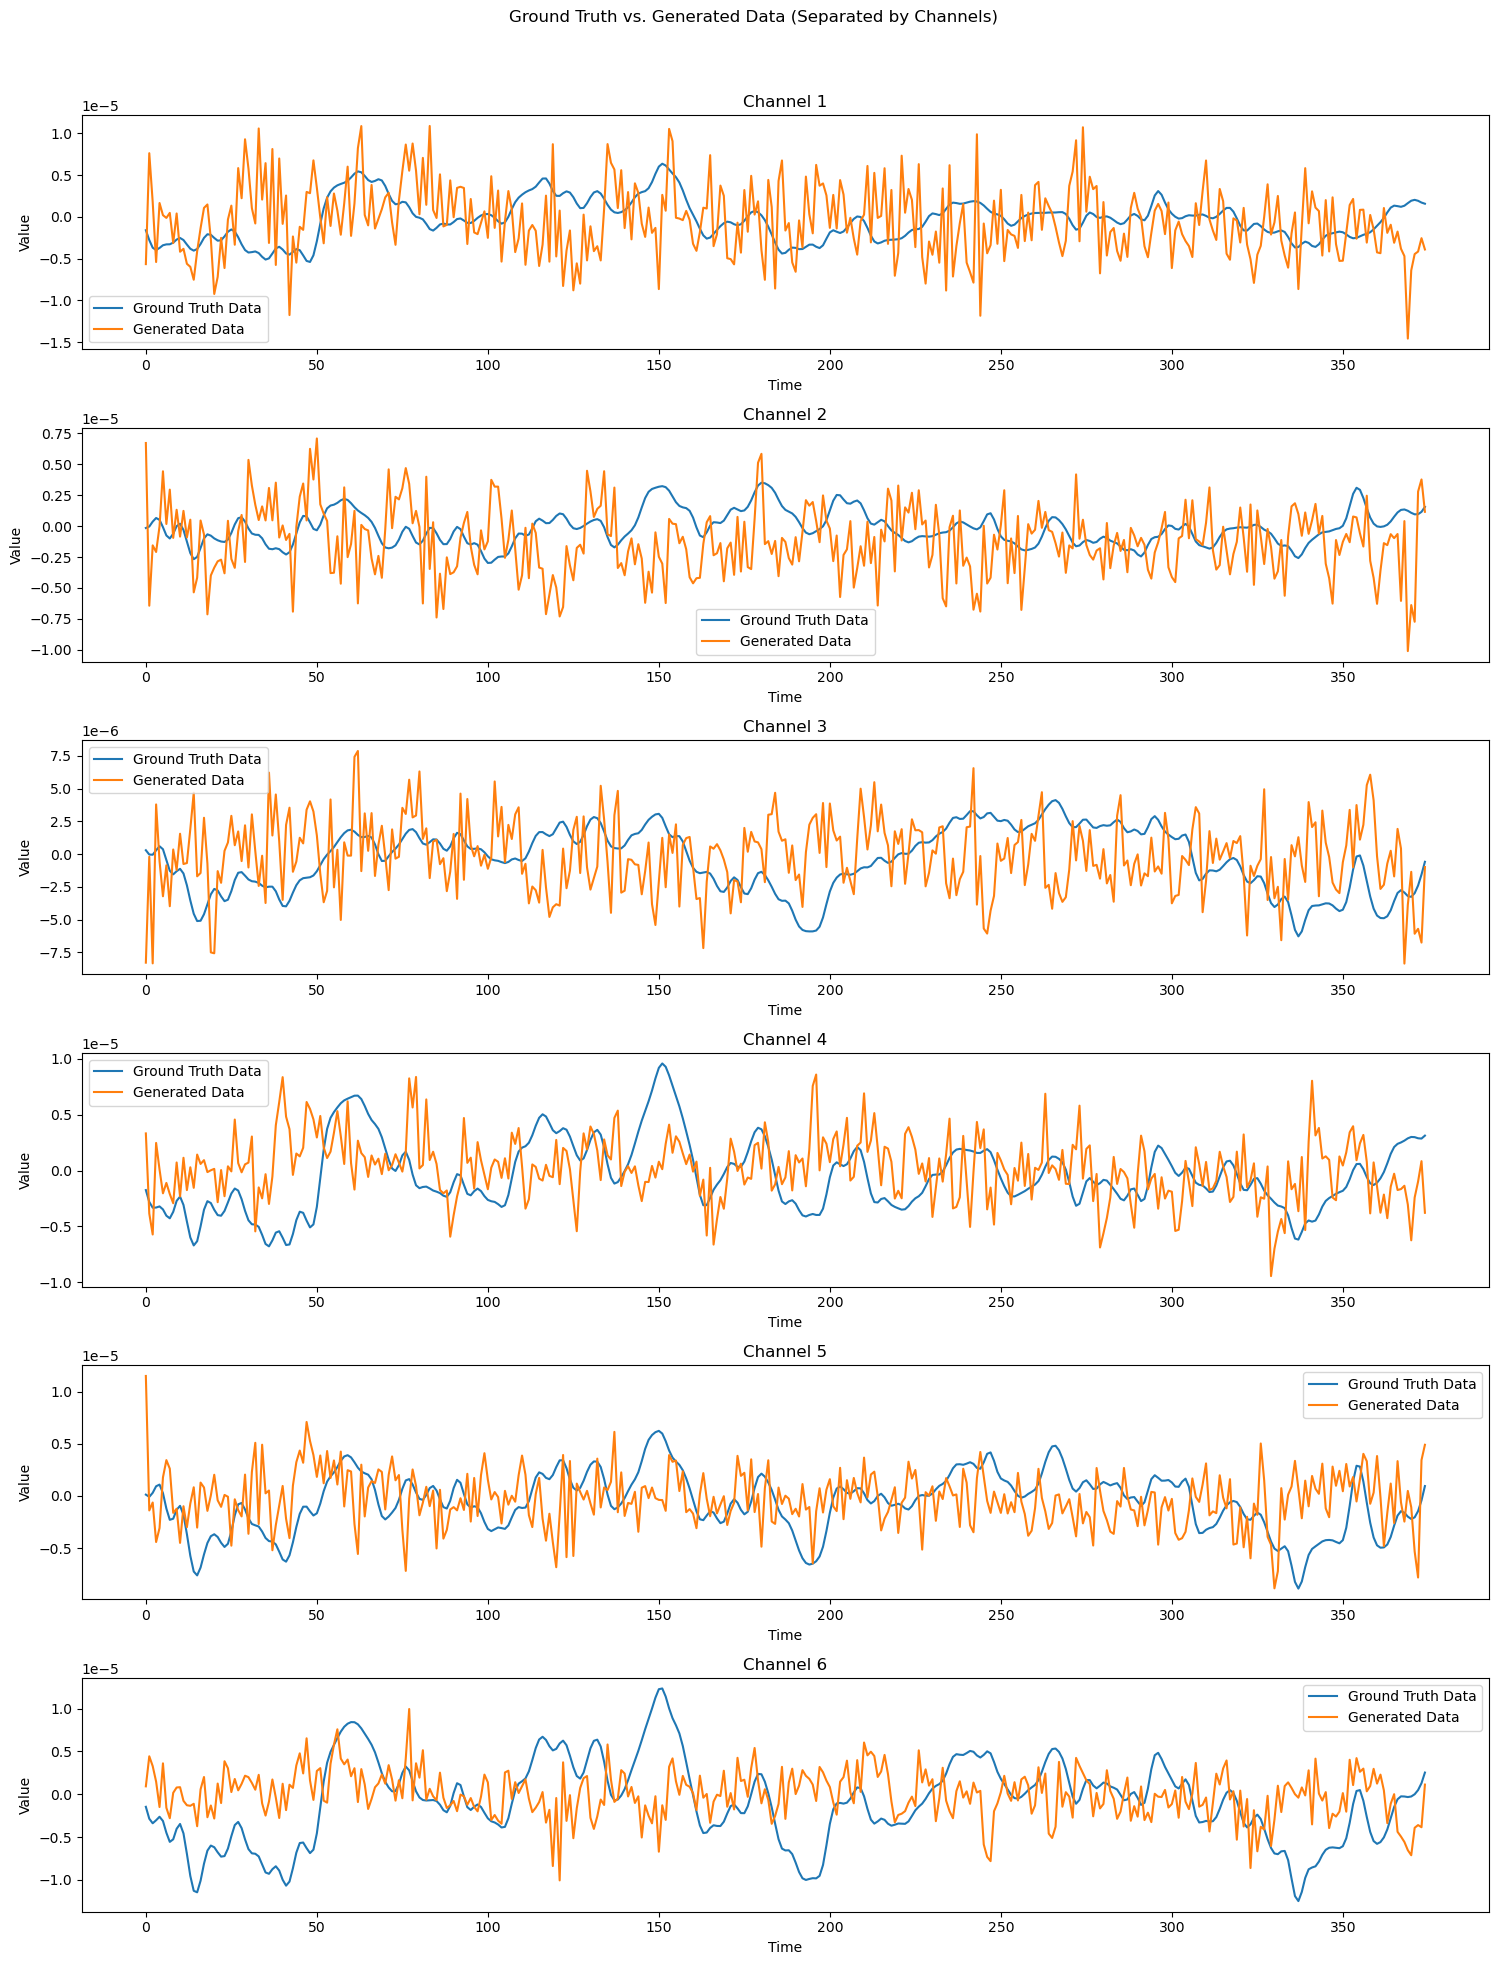

In [10]:
from scipy.stats import pearsonr

# Set the seed for reproducibility
np.random.seed(42)

# Generate a Gaussian distribution of size (6, 375)
gaussian_distribution = np.random.normal(loc=0, scale=1, size=(6, 375))

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Normalize the Gaussian distribution
normalized_distribution = min_max_normalize(gaussian_distribution)

data_scale_norm_distribution = dataset.inverse_transform_data(normalized_distribution, mode="numpy")

# generated_stn = data_scale_norm_distribution

# Flatten the arrays
eval_data_flattened = eval_data.flatten()
generated_data_flattened = generated_stn.flatten()
data_scale_norm_distribution_flattened = data_scale_norm_distribution.flatten()

correlation, _ = pearsonr(generated_data_flattened, eval_data_flattened)
correlation_2, _ = pearsonr(generated_data_flattened, data_scale_norm_distribution_flattened )

print("General Pearson correlation:", correlation)
print("Pearson correlation with Gaussian noise:", correlation_2)

# Ensure the data has 6 channels and the same shape
assert eval_data.shape == generated_stn.shape, "Shapes of evaluation and generated data must match."

for i in range(eval_data.shape[0]):
    correlation_generated, _ = pearsonr(generated_stn[i], eval_data[i])
    # correlation_ground_truth, _ = pearsonr(eval_data[0], eval_data[i])
    print( f"Correlation of generated data and ground truth at Channel {i+1}:",correlation_generated)
    # print( f"Correlation of ground truth data at Channel {i+1}:",correlation_ground_truth)
    print("-------------------------------------------------")


# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 20))
fig.suptitle('Ground Truth vs. Generated Data (Separated by Channels)')

# Plot each channel separately
for i in range(eval_data.shape[0]):
    axes[i].plot(eval_data[i], label='Ground Truth Data')
    axes[i].plot(generated_stn[i], label='Generated Data')
    axes[i].set_title(f'Channel {i + 1}')
    axes[i].legend()
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
# Path to your EMA model checkpoint
current_path = os.getcwd()
ema_model_path = os.path.join(current_path, 'models/DDPM_conditional/ema_diffusion_model_conditional.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ema_model = UNet_conditional().to(device)
ema_model.load_state_dict(torch.load(ema_model_path))

img_size = (6,375)

data_dir = os.path.join(current_path, 'model_training_data/train_set')

dataset = CustomDataset(data_dir , data_start = 'stn', label_start = 'ecog')

diffusion = Diffusion_Conditional(data_path=data_dir, img_size=img_size, device=device)

current_path = os.getcwd()
validation_dir = os.path.join(current_path, 'model_training_data/validation_set')

eval_data = np.load(validation_dir + '/stn_15.npy')
eval_label = np.load(validation_dir + '/ecog_15.npy')

# Normalize eval_label using the dataset instance
normal_eval_label = dataset.normalization_label(eval_label)
# pad_eval_label = padding(normal_eval_label,8)

# print("normal_eval_label shape:",pad_eval_label.shape)

# eval_label_torch = torch.tensor(pad_eval_label, dtype=torch.float32).unsqueeze(0)  # Update with actual path

# print("eval_label_torch shape:",eval_label_torch.shape)

normal_eval_label = torch.tensor(normal_eval_label, dtype=torch.float32).unsqueeze(0)

labels = flatten_last_two_dims(normal_eval_label)
labels = cos_embedding(labels, d_cross).to(device)

ema_generated_samples = diffusion.sample(model=ema_model, n=1, d_cross=160, labels=labels, data_start='stn', label_start='ecog', cfg_scale=3) 

04:14:57 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.67it/s]


In [12]:
print(ema_generated_samples.shape)

reduced_ema_generated_samples = ema_generated_samples[0, 0, :, :].cpu().numpy()

print(reduced_ema_generated_samples)

# generated_stn = dataset.inverse_transform_data(reduced_generated_samples,mode="numpy")
ema_generated_stn = reduced_ema_generated_samples
# generated_stn = dataset.inverse_transform_data(generated_stn,mode="numpy")

print(ema_generated_stn.shape)

max_ema_generated = np.max(ema_generated_stn)
print(max_ema_generated)
min_ema_generated = np.min(ema_generated_stn)
print(min_ema_generated)

max_GT = np.max(eval_data)
print(max_GT)
min_GT = np.min(eval_data)
print(min_GT)

generated_folder = current_path+ '/model_generated_data'
if not os.path.exists(generated_folder):
    os.makedirs(generated_folder)

generated_name = "ema_generated_stn_15"
np.save('%s/%s'%(generated_folder, generated_name), generated_stn)

torch.Size([1, 1, 6, 375])
[[-2.5770373e-06  6.7282235e-06  3.0671190e-06 ... -4.6205955e-06
  -2.6201603e-06  9.8122223e-07]
 [-2.4838198e-07 -4.8868292e-06 -2.9129194e-06 ...  8.7300992e-07
   6.2240692e-06  2.3396663e-06]
 [-5.0578922e-07  2.4385743e-06 -2.9436137e-06 ...  3.5427727e-06
   4.1182143e-06  8.5963065e-06]
 [ 2.3207624e-06  4.2285001e-06  9.2552369e-07 ... -2.7801289e-06
  -1.8002168e-06  2.3028424e-06]
 [-2.3065429e-06  5.0215003e-06  4.3646905e-06 ...  2.6975274e-06
  -3.2634946e-07  4.8323841e-06]
 [ 5.1245179e-06  3.5781104e-06  4.1533107e-07 ...  1.1483512e-06
   1.2883593e-06  2.6186131e-06]]
(6, 375)
1.3074416e-05
-9.2261735e-06
1.2358666936052032e-05
-1.2479285942390561e-05


general Pearson correlation: -0.08407498436756144
Correlation of generated data at Channel 1: 0.9999999999999993
Correlation of ground truth data at Channel 1: 1.0
-------------------------------------------------
Correlation of generated data at Channel 2: 0.17893804030076177
Correlation of ground truth data at Channel 2: 0.2934984215443261
-------------------------------------------------
Correlation of generated data at Channel 3: 0.21679484571984223
Correlation of ground truth data at Channel 3: 0.6190046279921378
-------------------------------------------------
Correlation of generated data at Channel 4: 0.24375597042036895
Correlation of ground truth data at Channel 4: 0.9121149520404768
-------------------------------------------------
Correlation of generated data at Channel 5: 0.12743722431184257
Correlation of ground truth data at Channel 5: 0.6708301856548179
-------------------------------------------------
Correlation of generated data at Channel 6: 0.2379886863361959
Cor

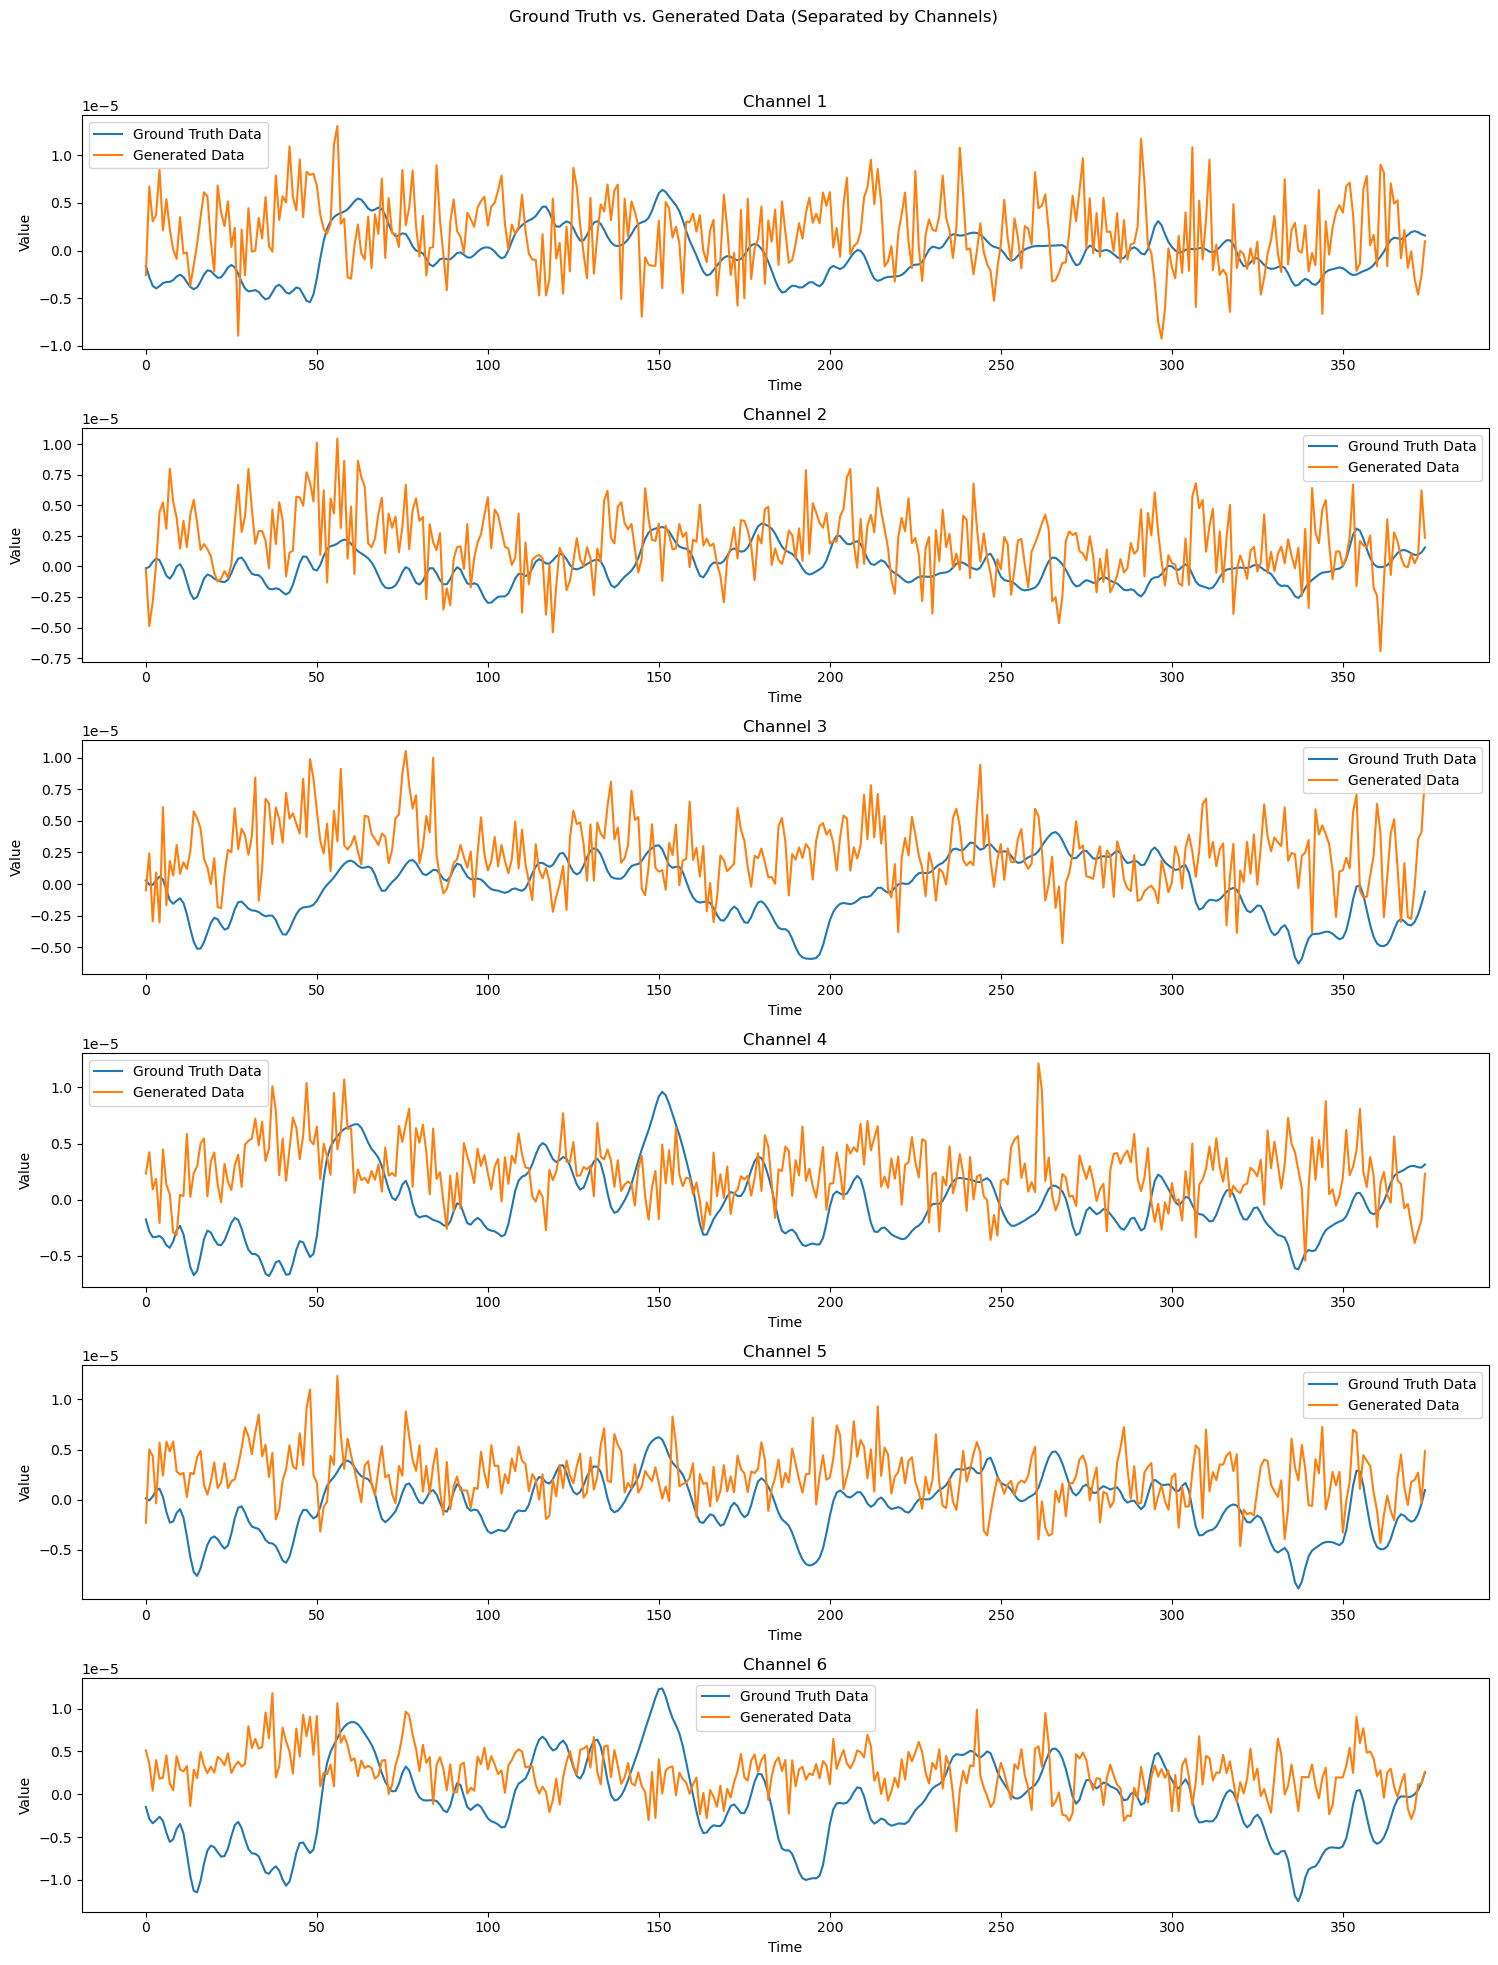

In [13]:
# Flatten the arrays
eval_data_flattened = eval_data.flatten()
generated_data_flattened = ema_generated_stn.flatten()

correlation, _ = pearsonr(generated_data_flattened, eval_data_flattened)

print("general Pearson correlation:", correlation)

# Ensure the data has 6 channels and the same shape
assert eval_data.shape == ema_generated_stn.shape, "Shapes of evaluation and generated data must match."

for i in range(eval_data.shape[0]):
    correlation_generated, _ = pearsonr(ema_generated_stn[0], ema_generated_stn[i])
    correlation_ground_truth, _ = pearsonr(eval_data[0], eval_data[i])
    print( f"Correlation of generated data at Channel {i+1}:",correlation_generated)
    print( f"Correlation of ground truth data at Channel {i+1}:",correlation_ground_truth)
    print("-------------------------------------------------")


# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 20))
fig.suptitle('Ground Truth vs. Generated Data (Separated by Channels)')

# Plot each channel separately
for i in range(eval_data.shape[0]):
    axes[i].plot(eval_data[i], label='Ground Truth Data')
    axes[i].plot(ema_generated_stn[i], label='Generated Data')
    axes[i].set_title(f'Channel {i + 1}')
    axes[i].legend()
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

current_path = os.getcwd()

validation_dir = os.path.join(current_path, 'model_training_data/validation_set')

data_dir = os.path.join(current_path, 'model_training_data/train_set')
data_start = 'stn'
label_start = 'ecog'

generated_folder = current_path+ '/model_generated_data'
if not os.path.exists(generated_folder):
    os.makedirs(generated_folder)

img_size = (6,375)

model_path = os.path.join(current_path, 'models/DDPM_conditional/diffusion_model_conditional.pt')
model = UNet_conditional().to(device)
model.load_state_dict(torch.load(model_path))

ema_model_path = os.path.join(current_path, 'models/DDPM_conditional/ema_diffusion_model_conditional.pt')
ema_model = UNet_conditional().to(device)
ema_model.load_state_dict(torch.load(ema_model_path))

# List all .npy files in the validation set
file_list = [f for f in os.listdir(validation_dir) if f.endswith('.npy')]

# # Function to load, process, and save generated data for each file
def generate_dataset(data_folder, data_start, label_start, model, ema_model, img_size, device, validation_folder, generated_folder):
    
    # Get files for ecog and stn
    ecog_files_list = sorted([f for f in os.listdir(validation_folder) if f.startswith('ecog_')])
    stn_files_list = sorted([f for f in os.listdir(validation_folder) if f.startswith('stn_')])

    for i in range(len(stn_files_list)):

        eval_data_name = stn_files_list[i]
        eval_data = np.load(validation_folder + '/' + eval_data_name)
        eval_label_name = ecog_files_list[i]
        eval_label = np.load(validation_folder + '/' + eval_label_name)

        dataset = CustomDataset(data_folder , data_start=data_start, label_start=label_start)

        diffusion = Diffusion_Conditional(data_path=data_folder, img_size=img_size, device=device)

        normal_eval_label = dataset.normalization_label(eval_label)
        # pad_eval_label = padding(normal_eval_label)
        # eval_label_torch = torch.tensor(pad_eval_label, dtype=torch.float32).unsqueeze(0) 
        normal_eval_label = torch.tensor(normal_eval_label, dtype=torch.float32).unsqueeze(0)

        labels = flatten_last_two_dims(normal_eval_label)
        labels = cos_embedding(labels, d_cross).to(device)

        generated_data =  diffusion.sample(model=model, n=1, d_cross=160, labels=labels, data_start='stn', label_start='ecog', cfg_scale=3) 
        ema_generated_data = diffusion.sample(model=ema_model, n=1, d_cross=160, labels=labels, data_start='stn', label_start='ecog', cfg_scale=3) 
        
        if not os.path.exists(generated_folder):
            os.makedirs(generated_folder)

        file_name = eval_data_name

        save_path = os.path.join(generated_folder, f'generated_{file_name}')
        ema_save_path = os.path.join(generated_folder, f'ema_generated_{file_name}')

        np.save(save_path, generated_data[0, 0, :, :].cpu().numpy())
        np.save(ema_save_path, ema_generated_data[0, 0, :, :].cpu().numpy())

# # Process each file
# for file_name in file_list:
#     process_and_save(file_name)
generate_dataset(data_folder=data_dir, data_start=data_start, label_start=label_start, model=model, ema_model=ema_model, img_size=img_size, device=device, validation_folder=validation_dir, generated_folder=generated_folder)

04:16:55 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
04:18:50 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.68it/s]
04:20:45 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.64it/s]
04:22:41 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
04:24:37 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
04:26:32 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:54,  8.69it/s]
04:28:27 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.64it/s]
04:30:23 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.64it/s]
04:32:19 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.68it/s]
04:34:14 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
04:36:09 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
04:38:05 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.62it/s]
04:40:01 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.68it/s]
04:41:56 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.62it/s]
04:43:52 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
04:45:47 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
04:47:43 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.67it/s]
04:49:38 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.63it/s]
04:51:34 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.62it/s]
04:53:30 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.68it/s]
04:55:25 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.63it/s]
04:57:21 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
04:59:17 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.64it/s]
05:01:12 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.67it/s]
05:03:08 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.63it/s]
05:05:03 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
05:06:59 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.67it/s]
05:08:54 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.66it/s]
05:10:50 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.66it/s]
05:12:45 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.63it/s]
05:14:41 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.67it/s]
05:16:36 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.62it/s]
05:18:32 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
05:20:28 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.64it/s]
05:22:24 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]
05:24:19 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.63it/s]
05:26:15 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:56,  8.61it/s]
05:28:11 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.66it/s]
05:30:06 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.
Found 159 data files and 159 label files.


999it [01:55,  8.62it/s]
05:32:02 - INFO: Sampling 1 new data based on label guidance....


Found 159 data files and 159 label files.


999it [01:55,  8.65it/s]


general Pearson correlation: 0.05932872631697579
Correlation of generated data at Channel 1: 1.0
Correlation of ground truth data at Channel 1: 1.0
-------------------------------------------------
Correlation of generated data at Channel 2: 0.22389967131808586
Correlation of ground truth data at Channel 2: 0.7706167405039704
-------------------------------------------------
Correlation of generated data at Channel 3: 0.025589095650041357
Correlation of ground truth data at Channel 3: -0.0191057130692905
-------------------------------------------------
Correlation of generated data at Channel 4: 0.12511741823455455
Correlation of ground truth data at Channel 4: 0.9731364547854819
-------------------------------------------------
Correlation of generated data at Channel 5: 0.09609287245860779
Correlation of ground truth data at Channel 5: 0.38294461298758864
-------------------------------------------------
Correlation of generated data at Channel 6: 0.1792167024938149
Correlation of g

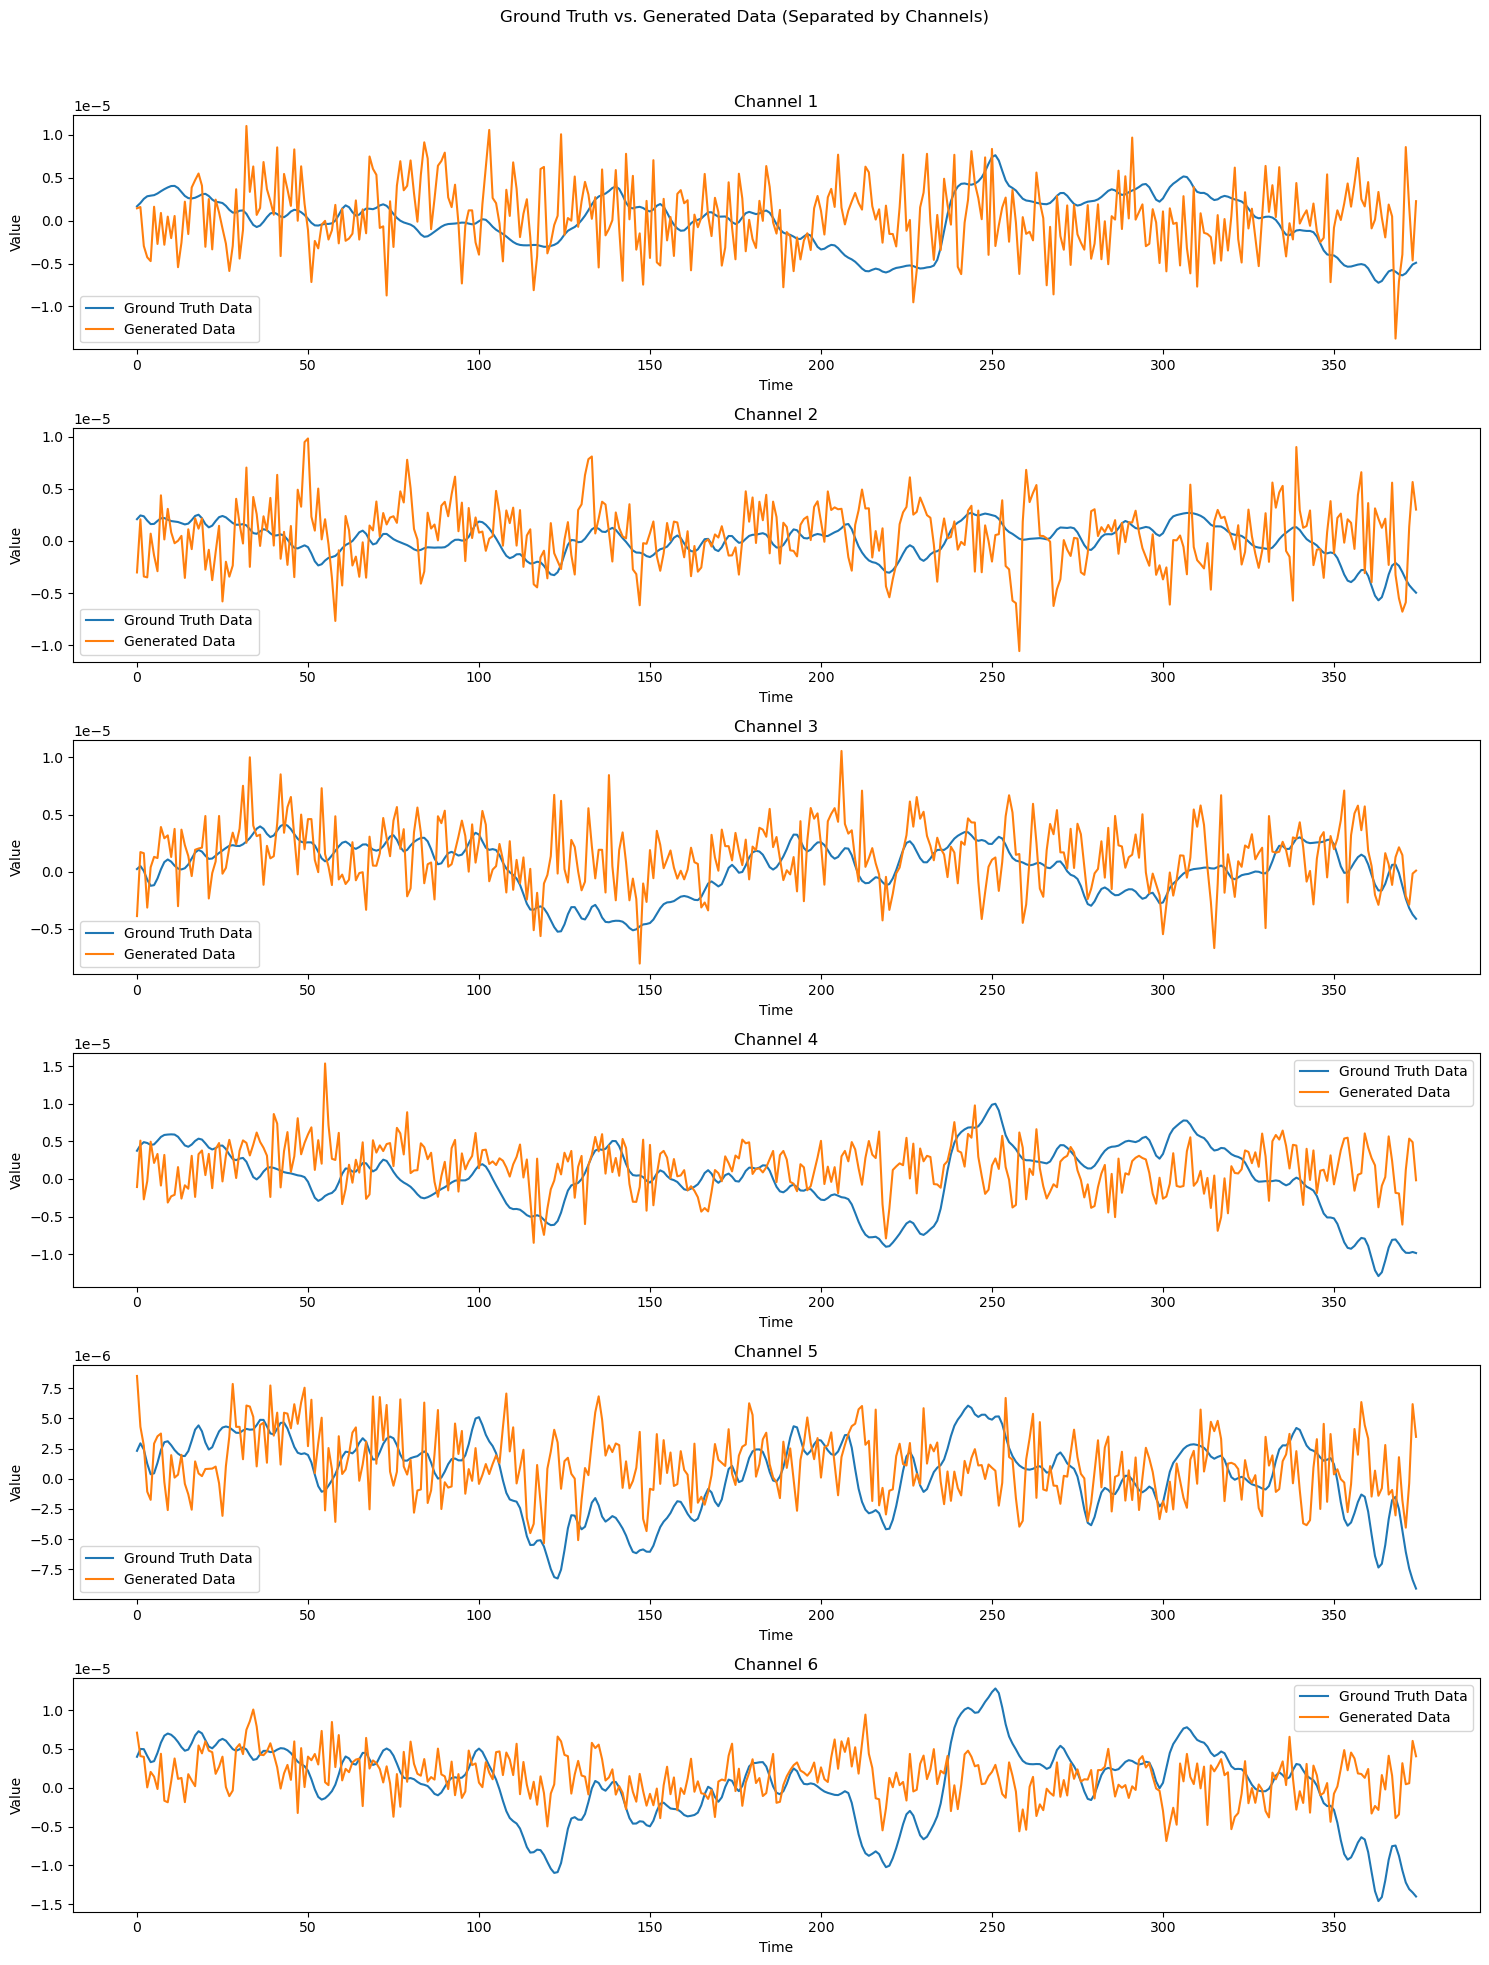

In [15]:
from scipy.stats import pearsonr


current_path = os.getcwd()
validation_dir = os.path.join(current_path, 'model_training_data/validation_set')
data_dir = os.path.join(current_path, 'model_training_data/train_set')
generated_folder = current_path+ '/model_generated_data'


eval_data = np.load(validation_dir + '/stn_16.npy')
generated_data = np.load(generated_folder + '/generated_stn_16.npy')

# Flatten the arrays
eval_data_flattened = eval_data.flatten()
generated_data_flattened = generated_data.flatten()

correlation, _ = pearsonr(generated_data_flattened, eval_data_flattened)

print("general Pearson correlation:", correlation)

# Ensure the data has 6 channels and the same shape
assert eval_data.shape == generated_data.shape, "Shapes of evaluation and generated data must match."

for i in range(eval_data.shape[0]):
    correlation_generated, _ = pearsonr(generated_data[0], generated_data[i])
    correlation_ground_truth, _ = pearsonr(eval_data[0], eval_data[i])
    print( f"Correlation of generated data at Channel {i+1}:",correlation_generated)
    print( f"Correlation of ground truth data at Channel {i+1}:",correlation_ground_truth)
    print("-------------------------------------------------")


# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 20))
fig.suptitle('Ground Truth vs. Generated Data (Separated by Channels)')

# Plot each channel separately
for i in range(eval_data.shape[0]):
    axes[i].plot(eval_data[i], label='Ground Truth Data')
    axes[i].plot(generated_data[i], label='Generated Data')
    axes[i].set_title(f'Channel {i + 1}')
    axes[i].legend()
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()